In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from itertools import product
from tqdm.auto import tqdm
import seaborn as sns


from analysis_utils import read_ann_df

data_dir = osp.abspath('../scenegram_data')
kilogram_dir = osp.abspath('../kilogram')
embedding_dir = osp.join(data_dir, 'clip_encodings')

fig_out_dir = osp.abspath(osp.join(os.pardir, 'collected_data', 'figures', 'vector_similarity'))
if not osp.isdir(fig_out_dir):
    os.makedirs(fig_out_dir)
    
sns.set_theme(style="ticks")

In [2]:
def norm_cos(cos):
    return 2.5 * max(cos, 0)

In [3]:
# annotation df
input_file = osp.join(data_dir, 'scenegram.csv')
ann_df = read_ann_df(input_file)
display(ann_df.head())

# sets and maps for tangrams / scenes
tangrams, scenes = zip(*ann_df.index)
tangrams = sorted(set(tangrams))
scenes = sorted(set(scenes))
tangram2idx = {t:i for i, t in enumerate(tangrams)}
idx2tangram = {i:t for t, i in tangram2idx.items()}

# pre-extracted features for scene images and annotations
ann_emb_file = np.load(osp.join(embedding_dir, 'ann_clip_embeddings.npz'), allow_pickle=True)
img_emb_file = np.load(osp.join(embedding_dir, 'scene_clip_embeddings.npz'), allow_pickle=True)

print('ann_emb_file entries: ', '; '.join(ann_emb_file.files))
print('img_emb_file entries: ', '; '.join(img_emb_file.files))

img_idx = img_emb_file['img_idx']
img_emb = img_emb_file['img_emb']

scene_img_embs = dict()
for scene in scenes:  
    # average embeddings for scene images 
    # to get one set of features per scene type
    mask = np.array([scene in i for i in img_idx])
    embs = img_emb[mask]
    mean_emb = img_emb[mask].mean(axis=0)
    scene_img_embs[scene] = mean_emb

text_idx = ann_emb_file['text_idx']
text_idx_df = pd.DataFrame(text_idx, columns=['identifyer', 'tangram', 'scene'])

text_raw_emb = ann_emb_file['text_raw_emb']
text_clean_emb = ann_emb_file['text_clean_emb']
text_head_emb = ann_emb_file['text_head_emb']
text_wn_emb = ann_emb_file['text_wn_emb']

# kilogram embeddings

kilogram_emb_file = np.load(osp.join(embedding_dir, 'dense_clip_embeddings.npz'), allow_pickle=True)
kilogram_clip_idx = pd.DataFrame(kilogram_emb_file['text_idx'], columns=['ann_id', 'tangram', 'ann_idx'])

kilogram_embs = dict()
for tangram in tangrams:
    mask = kilogram_clip_idx.tangram == tangram
    #avg_emb = kilogram_emb_file['text_emb'][mask].mean(axis=0)
    #kilogram_embs[tangram] = np.expand_dims(avg_emb, 0)
    kilogram_embs[tangram] = kilogram_emb_file['text_emb'][mask]

item_identifyer           raw_annotation  \
tangram scene                                                   
page-D  bathroom  3-bathroom-sws2_10    person reading a book   
        bathroom   3-bathroom-sws2_0       bathroom attendant   
        bathroom   3-bathroom-sws2_1                   PRIEST   
        bathroom  3-bathroom-sws2_15                   sliver   
        bathroom   3-bathroom-sws2_6  person holding arms out   

                         clean_annotation           head_noun   wn_lemma  \
tangram scene                                                              
page-D  bathroom    person reading a book              person     person   
        bathroom       bathroom attendant  bathroom attendant  attendant   
        bathroom                   priest              priest     priest   
        bathroom                   sliver              sliver   splinter   
        bathroom  person holding arms out              person     person   

                 selected_synset  \
tangram scene                      
page-D  bathroom     person.n.01   
        bathroom  attendant.n.01   
        bathroom     priest.n.01   
        bathroom   splinter.n.01   
        bathroom     person.n.01   

                                                  synset_definition  \
tangram scene                                                         
page-D  bathroom                                      a human being   
        bathroom  someone who waits on or tends to or attends to...   
        bathroom  a clergyman in Christian churches who has the ...   
        bathroom   a small thin sharp bit or wood or glass or metal   
        bathroom                                      a human being   

                  tangram_id  item_id        image_url partition_name  \
tangram scene                                                           
page-D  bathroom           3       35  035_grid_tr.png           sws2   
        bathroom           3       35  035_grid_tr.png           sws2   
        bathroom           3       35  035_grid_tr.png           sws2   
        bathroom           3       35  035_grid_tr.png           sws2   
        bathroom           3       35  035_grid_tr.png           sws2   

                 workspace_name tangram_pos  order_idx  time_delta  
tangram scene                                                       
page-D  bathroom        sws2_10          tr          9  208.936461  
        bathroom         sws2_0          tr          5  435.840241  
        bathroom         sws2_1          tr          3  130.278864  
        bathroom        sws2_15          tr         27  347.661279  
        bathroom         sws2_6          tr         32  408.685458

ann_emb_file entries:  text_idx; text_raw_emb; text_clean_emb; text_head_emb; text_wn_emb
img_emb_file entries:  img_idx; img_emb


## Calculate COHERENCE and SHIFT

In [ ]:
item_results = defaultdict(dict)

condition = 'head'
norm = True
_df = ann_df.reset_index()

combinations = list(product(tangrams, scenes))
for tangram, scene in tqdm(combinations):
    
    # retrieve text embeddings for contextualized anns
    scene_anns = _df.loc[np.logical_and(_df.tangram == tangram, _df.scene == scene)]
    scene_identifyer = scene_anns.item_identifyer.values
    item_mask = text_idx_df.identifyer.isin(scene_identifyer)
    context_text_emb = ann_emb_file[f'text_{condition}_emb'][item_mask]
    # mask out nan
    mask = ~np.array([np.isnan(c).any() for c in context_text_emb])
    context_text_emb = context_text_emb[mask]
    
    # retrieve text embeddings for baseline anns
    baseline_anns = _df.loc[np.logical_and(_df.tangram == tangram, _df.scene == 'none')]
    baseline_identifyer = baseline_anns.item_identifyer.values
    item_mask = text_idx_df.identifyer.isin(baseline_identifyer)
    baseline_text_emb = ann_emb_file[f'text_{condition}_emb'][item_mask]
    # mask out nan
    mask = ~np.array([np.isnan(c).any() for c in baseline_text_emb])
    baseline_text_emb = baseline_text_emb[mask]
    
    # retrieve img embs
    scene_img_emb = scene_img_embs[scene].reshape(1, -1)
    
    ###############################
    # compute COHERENCE and SHIFT #
    ###############################
    
    # compute cosine similarities between text and "image" embeddings
    context_cos = cosine_similarity(context_text_emb, scene_img_emb)    
    baseline_cos = cosine_similarity(baseline_text_emb, scene_img_emb)
    
    # normalize
    norm_context_cos = np.vstack(list(map(norm_cos, context_cos)))
    norm_baseline_cos = np.vstack(list(map(norm_cos, baseline_cos)))
    
    # mean -> COHERENCE scores
    ic_coherence = norm_context_cos.mean()
    bl_coherence = norm_baseline_cos.mean()
    
    # In-Context Coherence - Baseline Coherence = SHIFT scores
    shift = ic_coherence - bl_coherence
    
    item_results[(tangram, scene)]['In-Context COHERENCE'] = ic_coherence
    item_results[(tangram, scene)]['Baseline COHERENCE'] = bl_coherence
    item_results[(tangram, scene)]['SHIFT'] = shift
    
per_item_results = pd.DataFrame(item_results).T
per_item_results.index.names = ['tangram', 'scene']

  0%|          | 0/407 [00:00<?, ?it/s]

In [5]:
display(scene_anns.sample(3))
display(baseline_anns.sample(3))

,tangram,scene,item_identifyer,raw_annotation,clean_annotation,head_noun,wn_lemma,selected_synset,synset_definition,tangram_id,item_id,image_url,partition_name,workspace_name,tangram_pos,order_idx,time_delta
4060,page9-13,street,71-street-sws12_13,K,letter k,letter k,K,k.n.06,the 11th letter of the Roman alphabet,71,789,789_grid_bl.png,sws12,sws12_13,bl,14,379.235438
4061,page9-13,street,71-street-sws12_5,K,letter k,letter k,K,k.n.06,the 11th letter of the Roman alphabet,71,789,789_grid_bl.png,sws12,sws12_5,bl,25,363.054618
4062,page9-13,street,71-street-sws12_6,k,k,letter k,K,k.n.06,the 11th letter of the Roman alphabet,71,789,789_grid_bl.png,sws12,sws12_6,bl,4,105.211620


,tangram,scene,item_identifyer,raw_annotation,clean_annotation,head_noun,wn_lemma,selected_synset,synset_definition,tangram_id,item_id,image_url,partition_name,workspace_name,tangram_pos,order_idx,time_delta
4020,page9-13,none,71-none-bws0_11,ninja kick,ninja kick,ninja,ninja,ninja.n.01,a member of the ninja who were trained in mart...,71,781,781_grid_bl.png,bws0,bws0_11,bl,35,328.175697
4027,page9-13,none,71-none-bws0_10,two fish facing each other\n,fish,fish,fish,fish.n.01,any of various mostly cold-blooded aquatic ver...,71,781,781_grid_bl.png,bws0,bws0_10,bl,1,23.341203
4026,page9-13,none,71-none-bws0_1,K,k,letter k,K,k.n.06,the 11th letter of the Roman alphabet,71,781,781_grid_bl.png,bws0,bws0_1,bl,35,653.438562


# COHERENCE Plot (Figure 3)

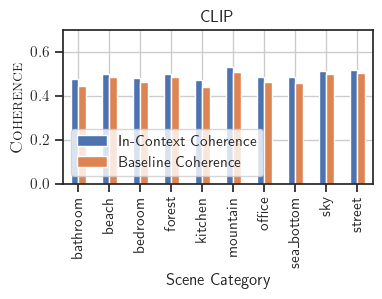

In [6]:
results = defaultdict(dict)

_r = per_item_results.reset_index()
_r = _r.loc[_r.scene != 'none']  # exclude baseline category, since in-context and baseline coherence are equal by definition

# average over scenes
for scene in pd.unique(_r.scene):
    results[scene]['In-Context Coherence'] = _r.loc[_r.scene == scene]['In-Context COHERENCE'].mean()
    results[scene]['Baseline Coherence'] = _r.loc[_r.scene == scene]['Baseline COHERENCE'].mean()
    
plt.rcParams['text.usetex'] = True

pd.DataFrame(results).T.plot(kind='bar', figsize=(4,2))
plt.grid()
plt.title('CLIP')
plt.xlabel('Scene Category')
plt.ylabel(r'\textsc{Coherence}')
plt.ylim((0,.7))
plt.legend(loc='lower left')

fname = f'CLIP_similarities.png'
out_path = osp.join(fig_out_dir, fname)
plt.savefig(out_path, bbox_inches='tight')
plt.show()

# SHIFT Plot

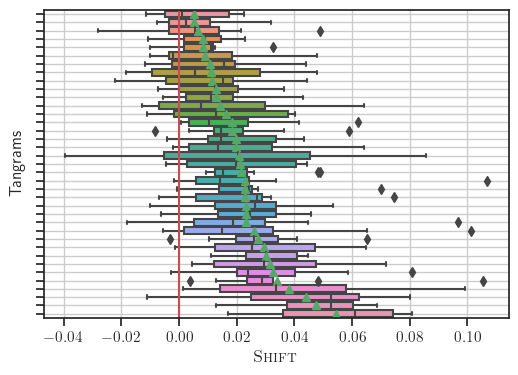

In [7]:
show_labels = False

_r = per_item_results.reset_index()
_r = _r.loc[_r.scene != 'none']  # exclude baseline category, since there's no shift by definition

fig, ax = plt.subplots(figsize=(6,4))    
order = _r.groupby('tangram')[f'SHIFT'].mean().sort_values().index
sns.boxplot(_r.reset_index(), y='tangram', x=f'SHIFT', order=order, showmeans=True)
plt.axvline(x = 0, color = 'r')
if show_labels:
    ax.set(ylabel='Tangrams', xlabel=r'\textsc{Shift}')  # with y tick labels
else:
    ax.set(yticklabels=[], ylabel='Tangrams', xlabel=r'\textsc{Shift}')  # without y tick labels
plt.grid()

In [8]:
_r.sort_values(by='SHIFT', ascending=False)[:10].reset_index(drop=True)

,tangram,scene,In-Context COHERENCE,Baseline COHERENCE,SHIFT
0,page5-153,bathroom,0.538219,0.431320,0.106899
1,page5-186,bathroom,0.540098,0.434550,0.105547
2,page8-235,mountain,0.592934,0.491580,0.101354
3,page1-128,kitchen,0.536932,0.437807,0.099125
4,page3-121,sea_bottom,0.535136,0.438293,0.096843
5,page1-0,bathroom,0.540589,0.454880,0.085709
6,page3-182,mountain,0.563924,0.483074,0.080850
7,page1-129,bathroom,0.519720,0.438934,0.080786
8,page7-26,bathroom,0.501363,0.421464,0.079898
9,page3-182,bathroom,0.500026,0.422777,0.077249
